shape of s_curve: (10000, 2)


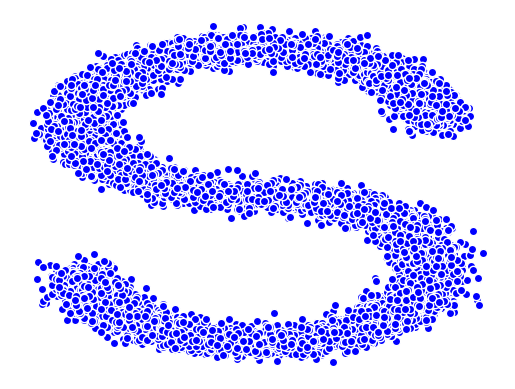

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

print("shape of s_curve:", s_curve.shape)

data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color = 'blue', edgecolor = 'white')

ax.axis('off')
dataset = torch.tensor(s_curve).float()

In [23]:
num_steps = 100

# 制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0)
alphas_prod_p = torch.cat([torch.tensor([1.0]), alphas_prod[:-1]], dim=0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape
print("all the same shape", betas.shape)

all the same shape torch.Size([100])


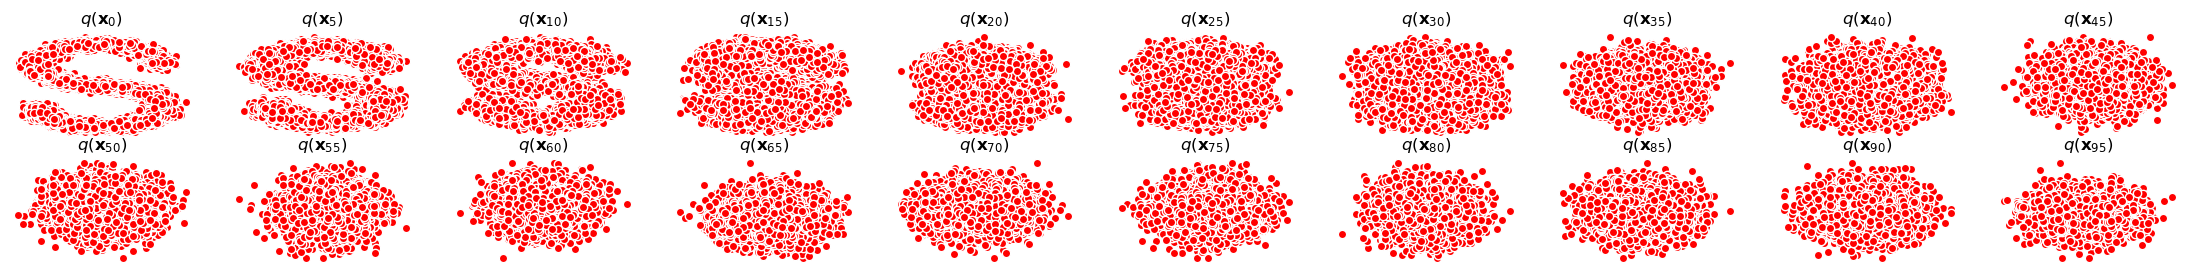

In [24]:
# 计算任意时刻的x的采样值，基于x_0和重参数化
def q_x(x_0, t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_l_m_t * noise)

num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='black')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows]))
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color = 'red', edgecolor = 'white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i * num_steps // num_shows)+'})$')

Training model ..
epoch: 0 loss: 0.6933382749557495
epoch: 100 loss: 0.4919429123401642
epoch: 200 loss: 0.2526233494281769
epoch: 300 loss: 0.2909085154533386
epoch: 400 loss: 0.13547328114509583


KeyboardInterrupt: 

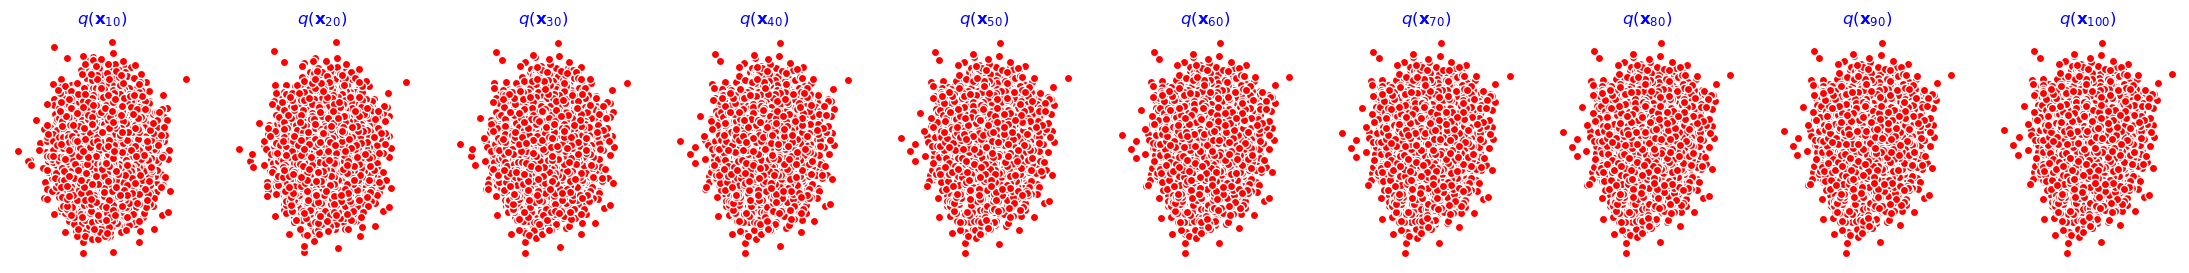

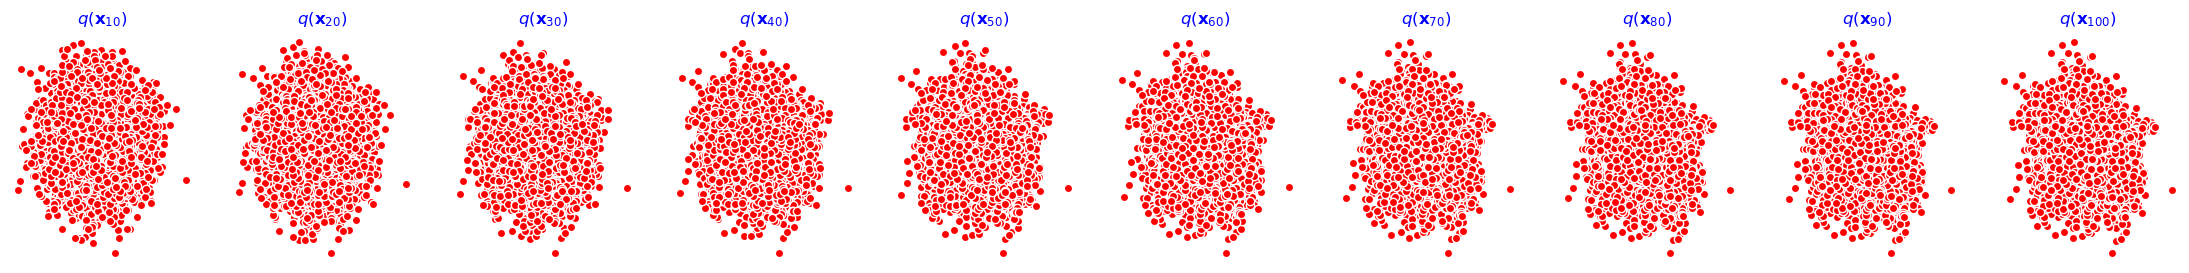

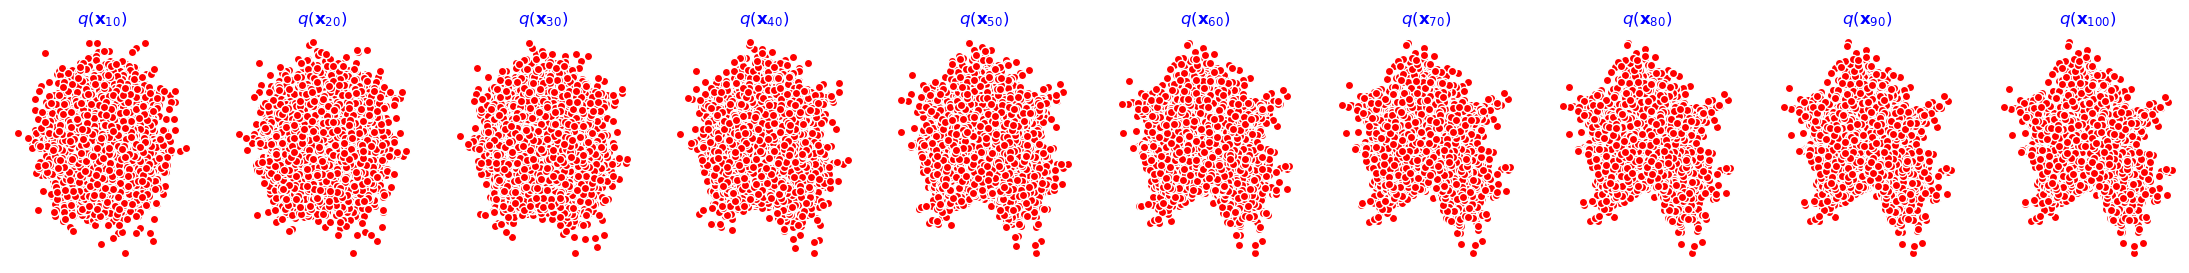

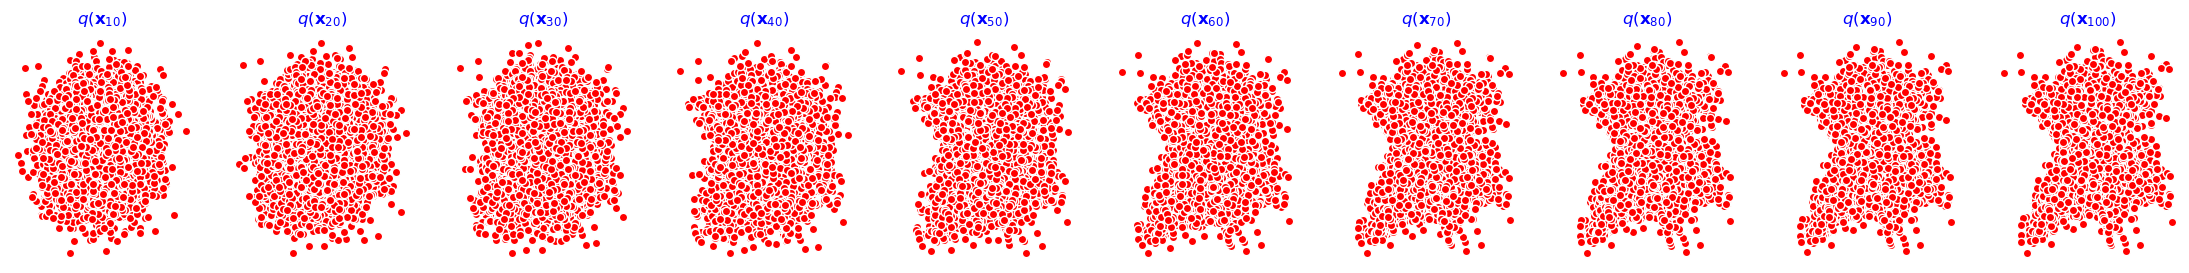

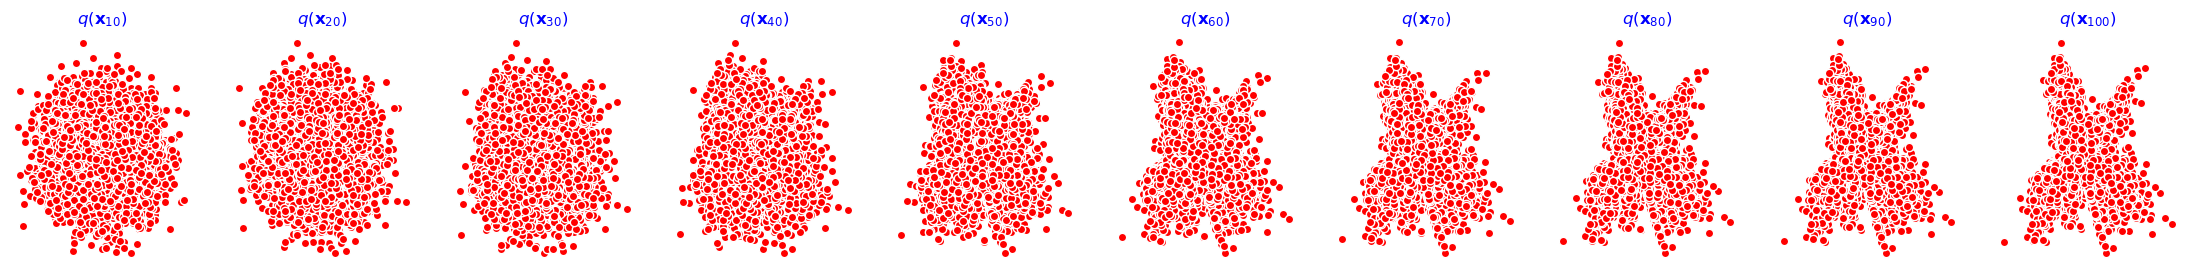

In [25]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units = 128):
        super().__init__()
        
        self.linears = nn.ModuleList([
            nn.Linear(2, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, 2),
        ])
        
        self.step_embeddings = nn.ModuleList([
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
        ])
        
    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)
            
        x = self.linears[-1](x)
        return x
    
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    
    t = torch.randint(0, n_steps, size = (batch_size//2,))
    t = torch.cat([t, n_steps - t - 1], dim = 0)
    t = t.unsqueeze(-1)
    
    a = alphas_bar_sqrt[t]
    aml = one_minus_alphas_bar_sqrt[t]
    e = torch.randn_like(x_0)
    x = x_0 * a + aml * e
    output = model(x, t.squeeze(-1))
    return (e - output).square().mean()    

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t].sqrt())) * (x - (coeff * eps_theta))
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

seed = 1234
print("Training model ..")
batch_size = 128
num_epoch = 4000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True )
plt.rc('text', color='blue')
    
model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    if t % 100 == 0:
        print("epoch:", t, "loss:", loss.item())
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color = 'red', edgecolor = 'white')
            axs[i - 1].set_axis_off()
            axs[i - 1].set_title('$q(\mathbf{x}_{'+str(i * 10)+'})$')

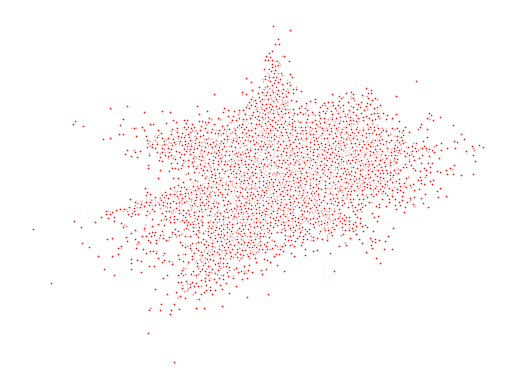

In [10]:
import io
from PIL import Image
imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color = 'red', edgecolor = 'white', s = 5)
    plt.axis('off')
    # BytesIO 是 Python 中的一个内置模块，它提供了一个类似于文件的接口，可以在内存中读写二进制数据。
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
    
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color = 'red', edgecolor = 'white', s = 5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)
